In [143]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import PromptTemplate, ChatMessagePromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langchain.chains import LLMChain
from langchain_core.tools import tool

from typing import Annotated, List, Dict
from typing_extensions import TypedDict
import pandas as pd
import numexpr
import math

## В качестве модели была выбрана llama3.1, используя ollama

In [144]:
llm = ChatOllama(model="llama3.1", temperature=0.1,
            base_url="http://192.168.0.103:11434")

## Для агента реализовано 3 инструмента
1. calculator - для вычисления арифметических операций
2. binary_to_decimal - перевод числа из двоичной системы счисления в десятичную
3. decimal_to_binary - перевод числа из десятичной системы счисления в двоичную

In [145]:
@tool
def calculator(expression: str) -> str:
    """Вычислите выражение с помощью библиотеки Python numexpr.
    Используй меня если нужно вычислить какое-то выражение.
    
    Выражение должно быть математическим выражением в одну строку, которое решает задачу.
    Примеры:
    "37593 * 67" для "37593 умножить на 67"
    "37593**(1/5)" для "37593^(1/5)"
    "sqrt(4)" для "корень из 4"
    
    :param expression: str - арифметическое выражение, состоящее из чисел и операций +, -, /, *, **, (, ), log, sqrt

    return:
    решение арифметического выражения
    """
    return str(
        numexpr.evaluate(
            expression.strip()
        )
    )

@tool
def binary_to_decimal(binary_number: str):
    """
    Перевод числа из двоичной системы счисления в десятичную. 

    :param binary_number": число в двоичной системе счисления 

    return: число в десятичной системе счисления 
    """

    return int(binary_number, 2)


@tool
def decimal_to_binary(decimal_number: int):
    """
    Перевод чисел из десятичной системы счисления в двоичную 

    :param decimal_number: число в десятичной системе счисления

    return: число в двоичной системе счисления
    """
    return int(bin(decimal_number)[2:])


@tool
def general_response(query: str) -> str:
    """
    Генерация ответа на общие вопросы и запросы, которые не попадают под другие инструменты. 
    Используется, когда запрос требует естественно-языкового ответа, объяснения, совета или не связан с вычислениями/конвертацией чисел.
    Отвечай 
    
    :param query: Текст запроса пользователя
    :return: Ответ, сгенерированный языковой моделью
    """
    return query

In [146]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    steps: list
    problem: str
    result: str

# Агент состоит из следующих частей
1. Шаг разбиения задачи на шаги
2. Поэтапное решение каждого шага, применяя инструменты и знания модели
3. Переформулирования решения задачи + самопроверка

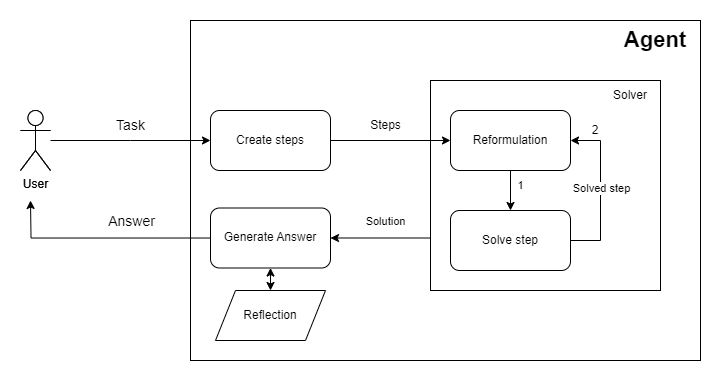

In [154]:
def create_steps(state):

    response_schemas = [
    ResponseSchema(name="steps", type="List[Dict]", description="Список шагов решения с объяснениями"),
    ]
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    
    # Шаблон промпта с инструкциями
    format_instructions = output_parser.get_format_instructions()
    
    prompt_template = """
    Разбейте следующую математическую задачу на основные шаги и предоставьте решение в структурированном виде.
    В каждом шаге - 1 действие. Шаги не должны повторяться.

    Инструкции:
    1. Разбейте задачу на последовательные логические шаги 
    2. Для каждого шага укажите:
       - Действие - что нужно сделать
       - Краткое объяснение - какие формулы, числа для этого использовать
       
    EXAMPLE #1
    Задача: Найти площадь прямоугольника со сторонами 4 м и 5 м. Перевести ответ в миллиметры.

    Шаги:
    Шаг 1. action: 'Найти площадь прямоугольника', explanation: 'Для этого нужно 4 умножить на 5'
    Шаг 2. action: 'Перевести полученную площадь в миллиметры.', explanation: 'Для этого нужно полученную площадь умножить на 100'
    END EXAMPLE #1

    EXAMPLE #2
    Задача: Найти площадь квадрата со стороной 7. Перевести ответ в двоичную систему счисления

    Шаги:
    Шаг 1. action: 'Найти площадь квадрата со стороной 7.', explanation: 'Для этого нужно 7 возвести в квадрат'
    Шаг 2. action: 'Перевести полученную площадь в двоичную систему счисления', explanation: 'Для этого нужно воспользоваться функцией для перевода в двоичную систему счисления'
    END EXAMPLE #2
    
    Задача: {problem}
    
    {format_instructions}
    """
    
    prompt = PromptTemplate(
        template=prompt_template,
        input_variables=["problem"],
        partial_variables={"format_instructions": format_instructions}
    )
    
    chain = LLMChain(llm=llm, prompt=prompt, output_parser=output_parser)

    result = chain.invoke({"problem": state['messages'][-1]})

    print("ПОЛУЧЕННЫЕ ШАГИ:", result['text']['steps'])
    return {"steps": result['text']['steps'], "problem": state['messages'][-1]}


def reformulation(solve_step: str, curr_task: str, problem: str) -> str:
    prompt = f"""
    Задача: {problem}
    
    На основе хода решения напиши кратко, что нужно сейчас сделать. 
    В качестве ответа используй полученные значения из хода решения
    
    Ход решения:
    {solve_step}
    
    Текущее действие: {curr_task}
    """

    result = llm.invoke(prompt)
    
    return result.content

def solve_step(prompt, solve_steps, i):
    add_prompt_tools = """Для решения задачи используй инструменты:
    calculator - если тебе нужно вычислить математическое выражение. Здесь должны быть только числа и арифметические операции.
    binary_to_decimal - если нужно перевести число из двоичной системы счисления в десятичную
    decimal_to_binary - если нужно перевести число из десятичной системы счисления в двоичную
    general_response - если задача не подходит ни к одному инструменту

    Задача:
    """
    new_prompt = add_prompt_tools + prompt
    print("Текущая задача:", new_prompt)
    llm_with_tool = llm.bind_tools(tools=[calculator, binary_to_decimal, decimal_to_binary, general_response], tool_choice='any')
    result = llm_with_tool.invoke(prompt)
    
    print()
    print("Используемые инструменты:", result.tool_calls)
    
    for tool_call in result.tool_calls:
        try:
            selected_tool = {"calculator": calculator, "binary_to_decimal": binary_to_decimal,
                            "decimal_to_binary": decimal_to_binary, "general_response": general_response}[tool_call["name"].lower()]
            
            if tool_call["name"].lower() == 'calculator':
                tool_call['args']["expression"] = tool_call['args']["expression"].replace("π", "3.14").replace("math.pi", "3.14").replace("math.", "").replace("^", "**").replace("pi", "3.14")
            elif tool_call["name"].lower() == 'general_response':
                solve_steps += f"Шаг {i}: " + str(prompt) + "\n\n"
                continue
                
            tool_msg = selected_tool.invoke(tool_call['args'])
            solve_steps += f"Шаг {i}: " + f"Функция: {tool_call['name']}, аргументы:{tool_call['args']}" + "\nОтвет: " + str(tool_msg) + "\n\n"
        except Exception as ex:
            print("Error -", ex)
            solve_steps += f"Шаг {i}: " + str(prompt) + "\n\n"

    return solve_steps
    
def solver(state):
    steps = state['steps']
    problem = state['problem']
    
    solve_steps = ""
    i = 1
    for step in steps:
        print("-----------------------")
        prompt = str(step)
        
        if len(solve_steps) > 0:
            prompt = reformulation(solve_steps, str(step), problem)
        
        solve_steps = solve_step(prompt, solve_steps, i)
        
        print()
        print("История:", solve_steps)
        i += 1
    return {"messages": [solve_steps]}

def generate_answer(state):
    prompt = SystemMessage(content=f"""
    Ты - преподаватель по математике. 
    Ученик сдал тебе свою работу по решению математической задачи. 
    Проверь правильность решения, правильность ответа и все ли необходимые шаги выполнены. Размышляй шаг за шагом, проверяя себя.
    Если есть ошибки, то исправь. Если ошибок нет, просто выведи решение и ответ.
    
    В ответ выведи решение задачи и ее ответ.

    Задача: {state['problem']}

    Ход решения:
    """)
    
    result = llm.invoke([prompt] + state['messages'])
    print("RESULT:", result.content)
    return {"messages": [result.content]}


In [155]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("create_steps", create_steps)
graph_builder.add_node("solver", solver)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "create_steps")
graph_builder.add_edge("create_steps", "solver")
graph_builder.add_edge("solver", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()

# Решение задач

In [156]:
tasks = [
    "Периметр прямоугольника со сторонами 1.5 м и 2 м. Ответ дай в сантиметрах.",
    "Найди сумму площадей круга с радиусом 5 см и круга с радиусом 3 см.",
    "Переведи числа 20 и 32 из десятичной в двоичную систему счисления и найди сумму единиц.",
    "Переведи числа из двоичной системы счисления 1101011010 и 101011 и посчитай их сумму.",
    "Найди объем цилиндра с радиусом 10 см и высотой 30 см, переведи результат в литры.",
    "Найди длину дуги окружности с радиусом 20 м, образованной центральным углом 60°, затем переведи результат в сантиметры.",
    "Переведи десятичное число 1524 в двоичную систему счисления и найди количество единиц в его двоичном представлении.",
    "Найти объем куба со стороной 5 см, затем перевести результат в двоичную систему счисления.",
    "Стороны треугольника соответственно равны 30 см, 40 см и 110010 см (переведи это число из двоичной системы счисления в десятичную). Найди площадь этого треугольника.",
    "Найди объемы двух цилиндров с радиусами 8 см и 12 см и высотами 20 см и 25 см соответственно, затем сложи эти объемы и переведи сумму в литры."
]

In [157]:
solve_d = {}
for i, task in enumerate(tasks):
    print("--------------------------------")
    print(f"Задача #{i+1}")
    print(task, "\n\n")
    
    state = graph.invoke({"messages": task})
    solve_d[task] = state['messages'][-1]

--------------------------------
Задача #1
Периметр прямоугольника со сторонами 1.5 м и 2 м. Ответ дай в сантиметрах. 


ПОЛУЧЕННЫЕ ШАГИ: [{'action': 'Найти периметр прямоугольника', 'explanation': 'Для этого нужно сложить длины всех сторон, т.е. 2*1.5 + 2*2'}, {'action': 'Перевести полученный результат в сантиметры', 'explanation': 'Поскольку в метрах получилось 9, то умножаем на 100, чтобы получить ответ в сантиметрах'}]
-----------------------
Текущая задача: Для решения задачи используй инструменты:
    calculator - если тебе нужно вычислить математическое выражение. Здесь должны быть только числа и арифметические операции.
    binary_to_decimal - если нужно перевести число из двоичной системы счисления в десятичную
    decimal_to_binary - если нужно перевести число из десятичной системы счисления в двоичную
    general_response - если задача не подходит ни к одному инструменту

    Задача:
    {'action': 'Найти периметр прямоугольника', 'explanation': 'Для этого нужно сложить длин

In [158]:
arr = [(task, solve.content) for task, solve in solve_d.items()]

In [166]:
df = pd.DataFrame(arr, columns=["task", 'answer'])

In [160]:
df.to_csv("last_result.csv", index=False)